# Main generator


In [65]:
import random
from ast import literal_eval
from copy import deepcopy
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

In [66]:
QWERTY_LOW_LAYOUT: list[list[str]] = [
    ["`", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "<back>"],
    ["<tab>", "q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "[", "]", "\\"],
    [
        "<caps>",
        "a",
        "s",
        "d",
        "f",
        "g",
        "h",
        "j",
        "k",
        "l",
        ";",
        "'",
        "<enter>",
        "<enter>",
    ],
    [
        "<shift>",
        "<shift>",
        "z",
        "x",
        "c",
        "v",
        "b",
        "n",
        "m",
        ",",
        ".",
        "/",
        "<shift>",
        "<shift>",
    ],
    [
        "<ctrl>",
        "<alt>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<alt>",
        "<ctrl>",
    ],
]

QWERTY_HIGH_LAYOUT: list[list[str]] = [
    ["~", "!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+", "<back>"],
    ["<tab>", "Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P", "{", "}", "|"],
    [
        "<caps>",
        "A",
        "S",
        "D",
        "F",
        "G",
        "H",
        "J",
        "K",
        "L",
        ":",
        '"',
        "<enter>",
        "<enter>",
    ],
    [
        "<shift>",
        "<shift>",
        "Z",
        "X",
        "C",
        "V",
        "B",
        "N",
        "M",
        "<",
        ">",
        "?",
        "<shift>",
        "<shift>",
    ],
    [
        "<ctrl>",
        "<alt>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<space>",
        "<alt>",
        "<ctrl>",
    ],
]

In [67]:
(
    len(QWERTY_HIGH_LAYOUT),
    len(QWERTY_HIGH_LAYOUT[0]),
    len(QWERTY_HIGH_LAYOUT[1]),
    len(QWERTY_HIGH_LAYOUT[2]),
    len(QWERTY_HIGH_LAYOUT[3]),
    len(QWERTY_HIGH_LAYOUT[4]),
)

(5, 14, 14, 14, 14, 11)

In [68]:
def get_buttons_set(
    low_layout: list[list[str]], high_layout: list[list[str]]
) -> set[str]:
    buttons: set[str] = set()

    for layout in [low_layout, high_layout]:
        for i in range(len(layout)):
            for btn in layout[i]:
                buttons.add(btn)

    return buttons


def get_keyboard_shape(layout: list[list[str]]) -> tuple[int, ...]:
    shape = [len(row) for row in layout]

    return tuple(shape)


BUTTONS_SET = get_buttons_set(QWERTY_LOW_LAYOUT, QWERTY_HIGH_LAYOUT)
KEYBOARD_LAYOUT_SHAPE = get_keyboard_shape(QWERTY_LOW_LAYOUT)
KEYBOARD_LAYOUT_CUMSUM_SHAPE = np.cumsum(KEYBOARD_LAYOUT_SHAPE)
KEYS = sum(KEYBOARD_LAYOUT_SHAPE) * 2

In [69]:
def get_encode_dicts() -> tuple[dict[tuple[int, int], int], dict[int, tuple[int, int]]]:
    pair_to_id = {}
    id_to_pair = {}
    counter = 0
    for i in range(134):
        for j in range(i + 1, 134):
            pair_to_id[(i, j)] = counter
            id_to_pair[counter] = (i, j)
            counter += 1
    return pair_to_id, id_to_pair


PAIR_TO_ID, ID_TO_PAIR = get_encode_dicts()
ACTION_SPACE_SIZE = len(PAIR_TO_ID)

In [70]:
def convert_int_to_cord(n: int) -> tuple[int, int, int]:
    shift = 0
    row = 0
    column = 0
    if n >= KEYS:
        return 2, 0, 0
    if n < 0:
        return 2, 0, 0
    if n >= KEYS // 2:
        n -= KEYS // 2
        shift = 1
    for i in range(len(KEYBOARD_LAYOUT_CUMSUM_SHAPE)):
        if n < KEYBOARD_LAYOUT_CUMSUM_SHAPE[i]:
            row = i
            break
    if row > 0:
        n -= KEYBOARD_LAYOUT_CUMSUM_SHAPE[row - 1]
    column = n
    return shift, row, column

In [71]:
KEYBOARD_LAYOUT_SHAPE

(14, 14, 14, 14, 11)

In [72]:
def encode_decode_buttons(buttons: set[str]) -> tuple[dict[str, int], dict[int, str]]:
    letters_dict = {}
    for idx, letter in enumerate("abcdefghijklmnopqrstuvwxyz"):
        letters_dict[letter] = idx + 1

    offset = len(letters_dict)
    for idx, letter in enumerate("abcdefghijklmnopqrstuvwxyz".upper()):
        letters_dict[letter] = offset + idx + 1

    encode_value = len(letters_dict) + 1
    encode_dict = {}
    decode_dict = {}
    for btn in buttons:
        if btn in letters_dict:
            decode_dict[letters_dict[btn]] = btn
            encode_dict[btn] = letters_dict[btn]
        else:
            decode_dict[encode_value] = btn
            encode_dict[btn] = encode_value
            encode_value += 1
    return encode_dict, decode_dict


ENCODE_DICT, DECODE_DICT = encode_decode_buttons(BUTTONS_SET)
ENCODED_BUTTONS_SET = {ENCODE_DICT[btn] for btn in BUTTONS_SET}
SHIFT_CODE = ENCODE_DICT["<shift>"]

In [73]:
for btn in BUTTONS_SET:
    assert btn == DECODE_DICT[ENCODE_DICT[btn]]

In [74]:
Layout = list[list[int]]


def encode_layout(layout: list[list[str]]) -> Layout:
    return [[ENCODE_DICT[btn] for btn in layout[i]] for i in range(len(layout))]


def decode_layout(layout: Layout) -> list[list[str]]:
    return [[DECODE_DICT[btn] for btn in layout[i]] for i in range(len(layout))]


QWERTY_ENCODED_HIGH: Layout = encode_layout(QWERTY_HIGH_LAYOUT)
QWERTY_ENCODED_LOW: Layout = encode_layout(QWERTY_LOW_LAYOUT)

In [75]:
def get_all_buttons_encoded(high_layout: Layout, low_layout: Layout) -> list[int]:
    all_buttons = []

    for layout in (low_layout, high_layout):
        for row in layout:
            all_buttons.extend(row)
    return all_buttons


ALL_BUTTONS_ENCODED = get_all_buttons_encoded(QWERTY_ENCODED_HIGH, QWERTY_ENCODED_LOW)

In [76]:
LogType = Literal["basic"] | Literal["debug"] | Literal["error"]


class Logger:
    def __init__(self, verbose: bool = True, hide_types: list[LogType] = []) -> None:
        self.verbose = verbose
        self.hide_types = set(hide_types)

    def log(self, message: str, log_type: LogType = "basic") -> None:
        if self.verbose and log_type not in self.hide_types:
            print(message)


LOGGER = Logger()

In [77]:
Position = tuple[int, int]


class Finger:
    def __init__(
        self, initial_position: Position, name: str, logger: Logger = LOGGER
    ) -> None:
        self.name = name
        self.initial_position = initial_position

        self.logger = logger

        self.reset()

        # Constants

        self.wait_before_return = 4  # in ticks

        self.long_row_move_shift = 3
        self.long_row_move_penalty = 1

        self.row_penalty_coefficient = 1
        self.column_penalty_coefficient = 1.2

    def reset(self):
        self.current_position = self.initial_position
        self.ticks_before_return = 0  # if == 0, returns to the initial position
        self.typed_keys = 0

    def move(self, position: Position):
        self.current_position = position

        self.ticks_before_return = self.wait_before_return
        self.typed_keys += 1

    def tick(self) -> float:
        if self.ticks_before_return > 0:
            self.ticks_before_return -= 1

        if self.ticks_before_return == 0:
            score = self.get_score(self.initial_position)
            self.current_position = self.initial_position
            return score

        return 0

    def get_score(self, target_position: Position) -> float:
        x1, y1 = self.current_position
        x2, y2 = target_position

        row_distance = abs(x1 - x2) ** 2
        column_distance = abs(y1 - y2) ** 2

        penalty = 0
        if row_distance > self.long_row_move_shift:
            penalty = self.long_row_move_penalty
        return (
            row_distance * self.row_penalty_coefficient
            + column_distance * self.column_penalty_coefficient
            + penalty
        )

    def show_statistics(self):
        self.logger.log(
            f"Name: {self.name:22} \
            Typed keys: {self.typed_keys:5} \
            Ticks before return: {self.ticks_before_return:5} \
            Current position: {self.current_position}\t\
            Default position: {self.initial_position}"
        )

In [78]:
DEFAULT_FINGERS: list[Finger] = [
    Finger((2, 1), "левый мизинец"),
    Finger((2, 2), "левый безымянный"),
    Finger((2, 3), "левый средний"),
    Finger((2, 4), "левый указательный"),
    Finger((4, 3), "левый большой"),
    Finger((4, 6), "правый большой"),
    Finger((2, 7), "правый указательный"),
    Finger((2, 8), "правый средний"),
    Finger((2, 9), "правый безымянный"),
    Finger((2, 10), "правый мизинец"),
]

SwapType = Literal["low_layout"] | Literal["high_layout"] | Literal["between_layouts"]


class KeyboardLayout:
    @staticmethod
    def layout_to_dict(
        layout: Layout, unused_layout: Layout
    ) -> dict[int, list[Position]]:
        layout_dict: dict[int, list[Position]] = {}

        for i in range(len(layout)):
            for j in range(len(layout[i])):
                button = layout[i][j]
                if button in layout_dict:
                    layout_dict[button].append((i, j))
                else:
                    layout_dict[button] = [(i, j)]

        for i in range(len(unused_layout)):
            for j in range(len(unused_layout[i])):
                button = unused_layout[i][j]
                if button not in layout_dict:
                    layout_dict[button] = []

        return layout_dict

    def _finish_move(self):
        for finger in self.fingers:
            self.total_score += finger.tick()

    def __init__(self, low_layout: Layout, high_layout: Layout, logger: Logger = LOGGER):
        self.low_layout = deepcopy(low_layout)
        self.high_layout = deepcopy(high_layout)

        self.low_layout_dict = KeyboardLayout.layout_to_dict(
            self.low_layout, self.high_layout
        )
        self.high_layout_dict = KeyboardLayout.layout_to_dict(
            self.high_layout, self.low_layout
        )

        self.logger = logger

        self.fingers = deepcopy(DEFAULT_FINGERS)

        self.reset()

    def reset(self):
        self.total_score: float = 0
        self.typed_keys: int = 0
        for f in self.fingers:
            f.reset()

    def move_one_finger(
        self, positions: list[Position], busy_finger_id: Optional[int] = None
    ) -> tuple[tuple[int, Position], float]:
        best_finger_id: int = 0
        best_score = np.inf

        final_position: Position = (0, 0)

        for position in positions:
            scores = [
                finger.get_score(position) if i != busy_finger_id else np.inf
                for i, finger in enumerate(self.fingers)
            ]

            candidate_finger_id = int(np.argmin(scores))
            candidate_score = scores[candidate_finger_id]

            if candidate_score < best_score:
                best_score = candidate_score
                best_finger_id = candidate_finger_id
                final_position = position

        return (best_finger_id, final_position), best_score

    def move_two_fingers(
        self, positions: list[Position]
    ) -> tuple[tuple[int, Position], tuple[int, Position], float]:
        shift_positions = self.low_layout_dict[SHIFT_CODE]
        if len(shift_positions) == 0:
            print("ERROR SHIFT IS UNREACHABLE")
            return (0, (0, 0)), (0, (0, 0)), 9999

        # firstly reach SHIFT, then - positions
        finger_shift_info_1, shift_distance_1 = self.move_one_finger(shift_positions)
        finger_btn_info_1, d1_btn = self.move_one_finger(
            positions, finger_shift_info_1[0]
        )
        total_distance_1 = shift_distance_1 + d1_btn

        # firstly reach positions, then - SHIFT
        finger_btn_info_2, d1_btn = self.move_one_finger(positions)
        finger_shift_info_2, shift_distance_2 = self.move_one_finger(
            shift_positions, finger_btn_info_2[0]
        )
        total_distance_2 = shift_distance_2 + d1_btn

        if total_distance_1 < total_distance_2:
            return finger_btn_info_1, finger_shift_info_1, total_distance_1

        return finger_btn_info_2, finger_shift_info_2, total_distance_2

    def find_button(self, button: int):
        if button in self.low_layout_dict and len(self.low_layout_dict[button]) > 0:
            (finger_id, finger_position), score = self.move_one_finger(
                self.low_layout_dict[button]
            )

            self.fingers[finger_id].move(finger_position)
            self.total_score += score
            self.typed_keys += 1

            self.logger.log(f"{button}:\t{self.fingers[finger_id].name}")

        elif button in self.high_layout_dict and len(self.high_layout_dict[button]) > 0:
            (
                (finger_id_1, finger_position_1),
                (finger_id_2, finger_position_2),
                score,
            ) = self.move_two_fingers(self.high_layout_dict[button])

            self.fingers[finger_id_1].move(finger_position_1)
            self.fingers[finger_id_2].move(finger_position_2)
            self.total_score += score
            self.typed_keys += 2

            self.logger.log(
                f"{button}:\t{self.fingers[finger_id_1].name} + {self.fingers[finger_id_2].name}"
            )

        else:
            self.logger.log(f"NO SUCH KEY: {button}")

        self._finish_move()

    def type_text(self, text: list[str]) -> float:
        for button in text:
            self.find_button(ENCODE_DICT[button])
        return self.total_score

    def type_encoded_text(self, encoded_text: list[int]) -> float:
        for button in encoded_text:
            self.find_button(button)
        return self.total_score

    def swap_buttons(self, position1: Position, position2: Position, swap_type: SwapType):
        if swap_type == "high_layout":
            layout_from = layout_to = self.high_layout
            layout_from_dict = layout_to_dict = self.high_layout_dict
        elif swap_type == "low_layout":
            layout_from = layout_to = self.low_layout
            layout_from_dict = layout_to_dict = self.low_layout_dict
        else:  # swap_type == "between_layouts"
            layout_from = self.low_layout
            layout_to = self.high_layout
            layout_from_dict = self.low_layout_dict
            layout_to_dict = self.high_layout_dict

        x1, y1 = position1
        btn1 = layout_from[x1][y1]
        x2, y2 = position2
        btn2 = layout_to[x2][y2]

        layout_from[x1][y1], layout_to[x2][y2] = layout_to[x2][y2], layout_from[x1][y1]

        layout_from_dict[btn1].remove(position1)
        layout_to_dict[btn2].remove(position2)

        layout_from_dict[btn2].append(position1)
        layout_to_dict[btn1].append(position2)

    def decode_layouts(self) -> tuple[list[list[str]], list[list[str]]]:
        return (decode_layout(self.low_layout), decode_layout(self.high_layout))

    def get_string_layouts(self) -> str:
        low_layout, high_layout = self.decode_layouts()
        result_string = "High layout:\n"
        for row in high_layout:
            for s in row:
                result_string += f"{s:8}"
            result_string += "\n"
        result_string += "\n"

        result_string += "\nLow layout:\n"
        for row in low_layout:
            for s in row:
                result_string += f"{s:8}"
            result_string += "\n"
        result_string += "\n"

        return result_string

    def show_statistics(self):
        self.logger.log("\nStatistics:")
        for f in self.fingers:
            f.show_statistics()

    def flatten(self):
        flatten = []
        for row in self.low_layout:
            flatten.extend(row)
        for row in self.high_layout:
            flatten.extend(row)

        flatten = [x / len(BUTTONS_SET) for x in flatten]
        return torch.as_tensor(flatten, dtype=torch.float32)

    def get_average_score(self) -> float:
        return self.total_score / self.typed_keys

In [79]:
def generate_random_layout(
    all_buttons_encoded: list[int],
    keyboard_shape: tuple[int, ...],
    seed: Optional[int] = None,
) -> tuple[Layout, Layout]:
    if seed is not None:
        random.seed(seed)

    all_buttons = all_buttons_encoded.copy()

    low_layout = [[0 for _ in range(row_length)] for row_length in keyboard_shape]
    high_layout = [[0 for _ in range(row_length)] for row_length in keyboard_shape]

    # Push single SHIFT to the low layout
    all_buttons.remove(SHIFT_CODE)
    random.shuffle(all_buttons)

    shift_position_low_layout = random.randint(0, len(all_buttons_encoded) // 2)
    all_buttons.insert(shift_position_low_layout, SHIFT_CODE)
    pointer = 0
    for layout in (low_layout, high_layout):
        for i, row_length in enumerate(keyboard_shape):
            for j in range(row_length):
                layout[i][j] = all_buttons[pointer]
                pointer += 1

    return low_layout, high_layout


sample_low_layout, sample_high_layout = generate_random_layout(
    ALL_BUTTONS_ENCODED, KEYBOARD_LAYOUT_SHAPE
)
sample_low_layout, sample_high_layout

([[91, 82, 84, 82, 56, 100, 64, 82, 63, 84, 31, 92, 82, 79],
  [59, 78, 34, 82, 55, 58, 39, 15, 11, 41, 97, 100, 54, 46],
  [90, 25, 81, 68, 82, 51, 49, 102, 8, 92, 17, 52, 12, 13],
  [66, 38, 74, 100, 44, 82, 96, 70, 50, 89, 40, 91, 14, 37],
  [71, 61, 29, 6, 84, 19, 5, 80, 84, 24, 30]],
 [[10, 88, 82, 9, 73, 48, 82, 85, 47, 22, 21, 4, 70, 72],
  [95, 77, 83, 96, 3, 82, 86, 65, 66, 7, 82, 76, 1, 100],
  [62, 36, 82, 84, 32, 67, 96, 75, 82, 99, 43, 42, 98, 2],
  [93, 84, 87, 92, 60, 20, 33, 53, 96, 27, 45, 94, 92, 84],
  [101, 57, 35, 16, 69, 28, 23, 82, 18, 26, 84]])

### Test Keyboard

In [80]:
qwerty_keyboard = KeyboardLayout(QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, LOGGER)
print(qwerty_keyboard.get_string_layouts())

High layout:
~       !       @       #       $       %       ^       &       *       (       )       _       +       <back>  
<tab>   Q       W       E       R       T       Y       U       I       O       P       {       }       |       
<caps>  A       S       D       F       G       H       J       K       L       :       "       <enter> <enter> 
<shift> <shift> Z       X       C       V       B       N       M       <       >       ?       <shift> <shift> 
<ctrl>  <alt>   <space> <space> <space> <space> <space> <space> <space> <alt>   <ctrl>  


Low layout:
`       1       2       3       4       5       6       7       8       9       0       -       =       <back>  
<tab>   q       w       e       r       t       y       u       i       o       p       [       ]       \       
<caps>  a       s       d       f       g       h       j       k       l       ;       '       <enter> <enter> 
<shift> <shift> z       x       c       v       b       n       m       ,       .       /    

In [81]:
print(qwerty_keyboard.low_layout_dict[ENCODE_DICT["s"]])
print(qwerty_keyboard.low_layout_dict[ENCODE_DICT["2"]])
print(qwerty_keyboard.high_layout_dict[ENCODE_DICT["S"]])
print(qwerty_keyboard.high_layout_dict[ENCODE_DICT["@"]])

[(2, 2)]
[(0, 2)]
[(2, 2)]
[(0, 2)]


In [82]:
qwerty_keyboard.swap_buttons((2, 2), (0, 2), "low_layout")
qwerty_keyboard.swap_buttons((2, 2), (0, 2), "high_layout")

print(qwerty_keyboard.low_layout_dict[ENCODE_DICT["s"]])
print(qwerty_keyboard.low_layout_dict[ENCODE_DICT["2"]])
print(qwerty_keyboard.high_layout_dict[ENCODE_DICT["S"]])
print(qwerty_keyboard.high_layout_dict[ENCODE_DICT["@"]])

[(0, 2)]
[(2, 2)]
[(0, 2)]
[(2, 2)]


In [83]:
print(qwerty_keyboard.low_layout[0][5])
print(qwerty_keyboard.high_layout[1][6])

63
51


In [84]:
qwerty_keyboard.swap_buttons((0, 5), (1, 6), "between_layouts")
print(qwerty_keyboard.low_layout[0][5])
print(qwerty_keyboard.high_layout[1][6])

51
63


In [85]:
qwerty_keyboard.show_statistics()


Statistics:
Name: левый мизинец                      Typed keys:     0             Ticks before return:     0             Current position: (2, 1)	            Default position: (2, 1)
Name: левый безымянный                   Typed keys:     0             Ticks before return:     0             Current position: (2, 2)	            Default position: (2, 2)
Name: левый средний                      Typed keys:     0             Ticks before return:     0             Current position: (2, 3)	            Default position: (2, 3)
Name: левый указательный                 Typed keys:     0             Ticks before return:     0             Current position: (2, 4)	            Default position: (2, 4)
Name: левый большой                      Typed keys:     0             Ticks before return:     0             Current position: (4, 3)	            Default position: (4, 3)
Name: правый большой                     Typed keys:     0             Ticks before return:     0             Current position:

In [86]:
qwerty_keyboard.type_text(list("Procrastination!"))

42:	правый мизинец + левый мизинец
18:	левый указательный
15:	правый безымянный
3:	левый средний
18:	левый указательный
1:	левый мизинец
19:	левый безымянный
20:	левый указательный
9:	правый средний
14:	правый указательный
1:	левый мизинец
20:	левый указательный
9:	правый средний
15:	правый безымянный
14:	правый указательный
99:	левый мизинец + левый безымянный


44.400000000000006

In [87]:
qwerty_keyboard.show_statistics()


Statistics:
Name: левый мизинец                      Typed keys:     4             Ticks before return:     3             Current position: (0, 1)	            Default position: (2, 1)
Name: левый безымянный                   Typed keys:     2             Ticks before return:     3             Current position: (3, 1)	            Default position: (2, 2)
Name: левый средний                      Typed keys:     1             Ticks before return:     0             Current position: (2, 3)	            Default position: (2, 3)
Name: левый указательный                 Typed keys:     4             Ticks before return:     0             Current position: (2, 4)	            Default position: (2, 4)
Name: левый большой                      Typed keys:     0             Ticks before return:     0             Current position: (4, 3)	            Default position: (4, 3)
Name: правый большой                     Typed keys:     0             Ticks before return:     0             Current position:

As we can see, we successfully can swap different keys in given keyboard and calculate distance function fro given string.


## Data loading & preprocessing

In [88]:
data_points = pd.read_csv("../data/raw/encoded_programs.csv", index_col=0)
data_points.head()

,encoded_text
0,"[16, 15, 9, 14, 20, 57, 15, 16, 5, 18, 1, 20, ..."
1,"[9, 14, 20, 57, 13, 1, 9, 14, 61, 97, 57, 64, ..."
2,"[9, 14, 20, 57, 13, 1, 9, 14, 61, 97, 99, 100,..."
3,"[9, 14, 20, 57, 13, 1, 9, 14, 61, 97, 57, 64, ..."
4,"[57, 57, 9, 14, 20, 57, 13, 1, 9, 14, 61, 97, ..."


In [89]:
dataset = np.array(
    [np.array(text) for text in data_points["encoded_text"].apply(literal_eval).to_list()]
)
dataset.shape

(1000, 400)

In [90]:
LIMIT_DATA: int = 10  # use only several data points
data = dataset[:LIMIT_DATA]

## Measure QWERTY

In [116]:
qwerty_keyboard = KeyboardLayout(
    QWERTY_ENCODED_LOW, QWERTY_ENCODED_HIGH, Logger(verbose=False)
)

random_low, random_high = generate_random_layout(
    ALL_BUTTONS_ENCODED, KEYBOARD_LAYOUT_SHAPE, seed=42
)
random_keyboard = KeyboardLayout(random_low, random_high, Logger(verbose=False))


loop = tqdm(data)
for text in loop:
    qwerty_score_total = qwerty_keyboard.type_encoded_text(text)
    random_score_total = random_keyboard.type_encoded_text(text)
    loop.set_postfix({"qwerty": qwerty_score_total, "random": random_score_total})

  0%|          | 0/10 [00:00<?, ?it/s, qwerty=1.65e+3, random=2.01e+3]

100%|██████████| 10/10 [00:00<00:00, 15.80it/s, qwerty=1.56e+4, random=1.47e+4]


In [117]:
print(qwerty_keyboard.get_string_layouts())

High layout:
~       !       @       #       $       %       ^       &       *       (       )       _       +       <back>  
<tab>   Q       W       E       R       T       Y       U       I       O       P       {       }       |       
<caps>  A       S       D       F       G       H       J       K       L       :       "       <enter> <enter> 
<shift> <shift> Z       X       C       V       B       N       M       <       >       ?       <shift> <shift> 
<ctrl>  <alt>   <space> <space> <space> <space> <space> <space> <space> <alt>   <ctrl>  


Low layout:
`       1       2       3       4       5       6       7       8       9       0       -       =       <back>  
<tab>   q       w       e       r       t       y       u       i       o       p       [       ]       \       
<caps>  a       s       d       f       g       h       j       k       l       ;       '       <enter> <enter> 
<shift> <shift> z       x       c       v       b       n       m       ,       .       /    

In [118]:
print(f"{qwerty_keyboard.total_score=:.0f}")
print(f"{random_keyboard.total_score=:.0f}")

qwerty_keyboard.total_score=15619
random_keyboard.total_score=14741


In [107]:
print(random_keyboard.get_string_layouts())

High layout:
H       &       V       <tab>   8       p       v       l       <space> 0       <space> q       @       <space> 
5       g       X       x       c       =       n       N       <space> |       <ctrl>  t       G       z       
>       "       y       D       `       <space> ?       <space> <ctrl>  <shift> <shift> O       E       {       
[       %       M       _       <alt>   a       \       <shift> 3       4       <shift> (       -       #       
B       <space> Y       <back>  <caps>  j       <space> <space> $       6       <caps>  


Low layout:
]       m       F       b       <enter> u       1       :       d       ^       9       w       <alt>   '       
<shift> U       7       P       s       <space> .       <alt>   C       ,       f       K       <space> <ctrl>  
r       <alt>   Q       *       <shift> k       2       !       Z       S       <tab>   }       /       <shift> 
<space> R       W       h       J       <space> ;       <       <enter> A       <enter> <spac

In [102]:
qwerty_keyboard.total_score

15619.400000000267

## Score estimator 

In [95]:
def generate_random_layouts(n: int) -> list[KeyboardLayout]:
    layouts = []
    for i in range(n):
        random_low, random_high = generate_random_layout(
            ALL_BUTTONS_ENCODED, KEYBOARD_LAYOUT_SHAPE, seed=i
        )
        layouts.append(KeyboardLayout(random_low, random_high, Logger(verbose=False)))
    return layouts


def estimate_layouts(layouts: list[KeyboardLayout], dataset: np.ndarray) -> torch.Tensor:
    loop = tqdm(dataset)
    for layout in layouts:
        layout.reset()
    for text in loop:
        for layout in layouts:
            layout.type_encoded_text(text)

    return torch.as_tensor([layout.total_score for layout in layouts])

In [96]:
LAYOUTS_NUMBER = 5

random_layouts = generate_random_layouts(LAYOUTS_NUMBER)
random_layouts_scores = estimate_layouts(random_layouts, data)

100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


In [97]:
BEST_RANDOM = min(random_layouts_scores).item()
print(f"{BEST_RANDOM=}")

BEST_RANDOM=12208.2001953125


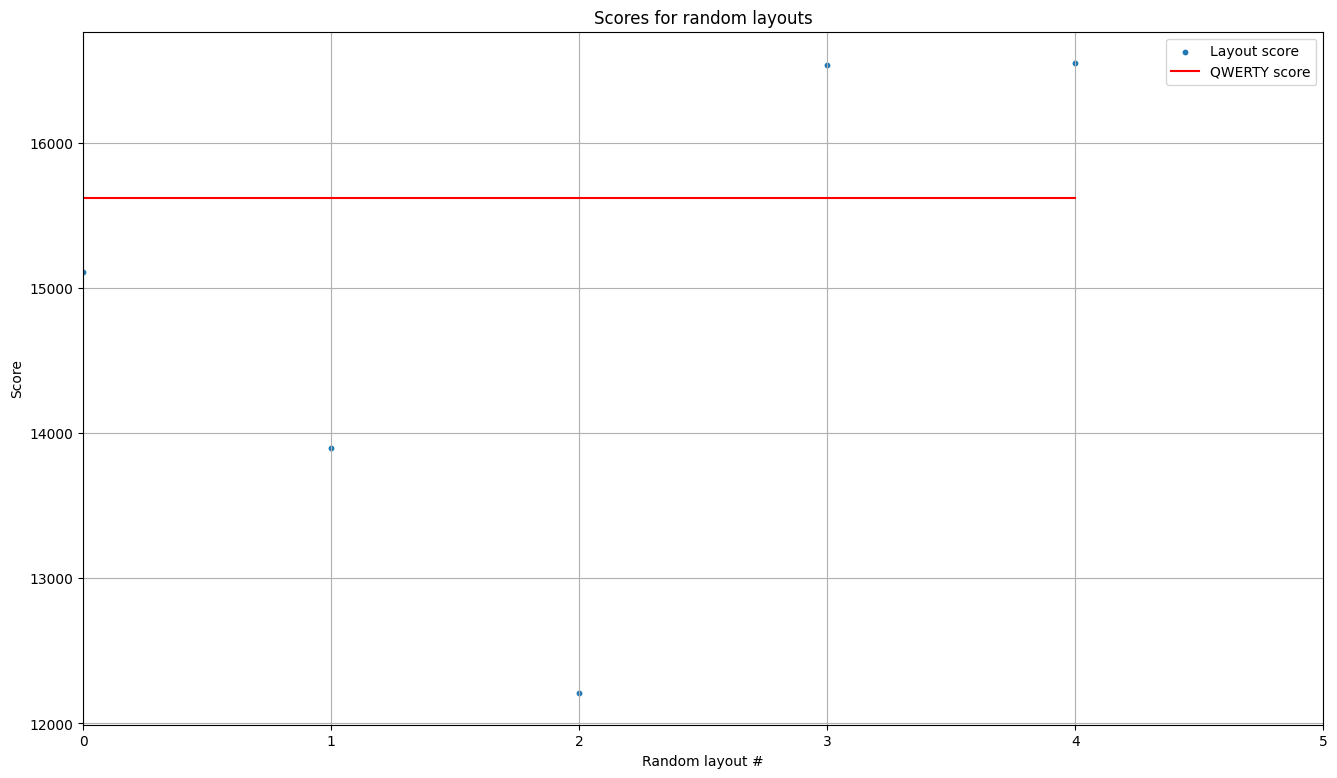

In [98]:
def plot_scores(
    scores: torch.Tensor,
    x_lim: Optional[float] = None,
    figsize: tuple[int, int] = (16, 9),
):
    qwerty_scores = [qwerty_keyboard.total_score for _ in range(len(scores))]
    random_scores = [x.item() for x in scores]
    plt.subplots(1, 1, figsize=figsize)
    points = list(range(len(random_scores)))
    plt.scatter(points, random_scores, s=10, label="Layout score")
    plt.plot(qwerty_scores, label="QWERTY score", color="red")
    plt.legend()
    plt.grid()
    if x_lim is None:
        x_lim = len(random_scores)
    plt.xlim([0, x_lim])
    plt.ylabel("Score")
    plt.xlabel("Random layout #")
    plt.title("Scores for random layouts")
    plt.show()


plot_scores(random_layouts_scores)

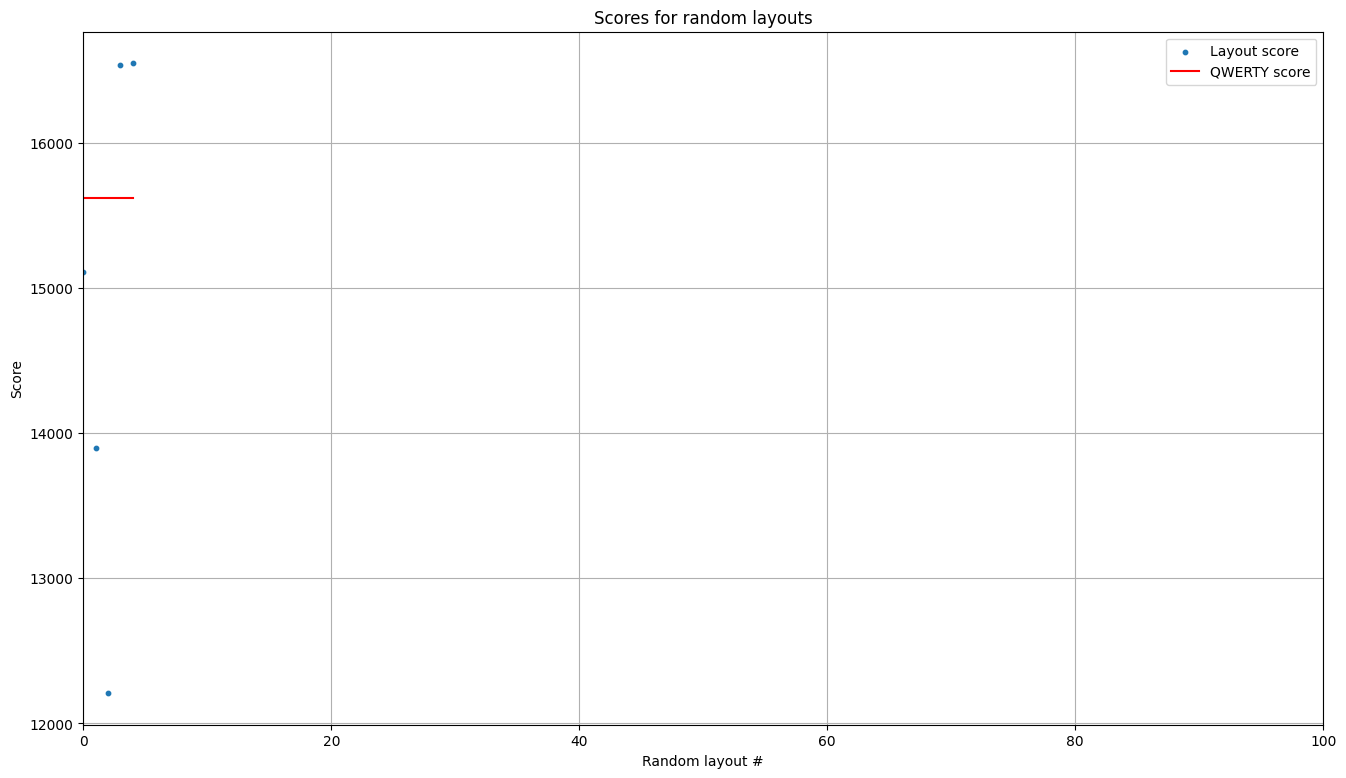

In [99]:
plot_scores(random_layouts_scores, x_lim=100)

In [100]:
best_layout_idx = np.argmin(random_scores)
best_layout = np.argmin(random_layouts[best_layout_idx])
print(best_layout.get_string_layouts())

IndexError: list index out of range